In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import biogeme.vns as vns
import biogeme.database as db

# Pareto reader

This notebook is used to display the information contained in the Pareto set generated by the algorithm, and saved in the pickle file. 

We need the following just to know the sample size. 

In [2]:
df = pd.read_csv('airline.dat', '\t')

# Update some data
df.loc[df['q17_Gender'] == 99, 'q17_Gender'] = -1
df.loc[df['q20_Education'] == 99, 'q20_Education'] = -1

database = db.Database('airline', df)
globals().update(database.variables)

exclude = (ArrivalTimeHours_1 == -1)
database.remove(exclude)
sampleSize = database.getSampleSize()
sampleSize

3609

The information about the approximation of the Pareto set is saved regularly by the algorithm in a pickle file. We first open it. 

In [3]:
pickleFile = 'airlinePareto.pickle'

In [4]:
pareto = vns.paretoClass(20, archiveInputFile=pickleFile)

In [5]:
print(f'Number of pareto solutions: {len(pareto.pareto)}')

Number of pareto solutions: 17


We calculate the AIC and the BIC for non dominated each model.

In [6]:
def AIC(k, LL):
    """Calculate the Aikaike Information Criterion for a model with k parameters and final log liklelihood LL"""
    return 2 * k - 2 * LL

In [7]:
def BIC(k, LL):
    """Calculate the Bayesian Information Criterion for a model with k parameters and final log liklelihood LL"""
    return k * np.log(sampleSize) - 2 * LL


## List of Pareto solutions: performance measures

In [8]:
bestBIC = None
bestAIC = None
summary = []
besti = -1
bestj = -1
for p in pareto.pareto:
    res = ''
    for t, r in zip(p.objectivesNames, p.objectives):
        res += f'{t}: {r}\t'
    L = p.objectives[0]
    k = p.objectives[1]
    A = AIC(k, -L)
    B = BIC(k, -L)
    res += f'BIC = {B:.3f}\tAIC = {A:.3f}'
    summary.append(res)
    if bestBIC is None or B < bestBIC:
        bestBIC = B
        besti = len(summary) - 1
    if bestAIC is None or A < bestAIC:
        bestAIC = A
        bestj = len(summary) - 1
for i in range(len(summary)):
    if i == besti:
        if i == bestj:
            pre = f'{i+1:3} **'
    elif i == bestj:
        pre = f'{i+1:3} A*'
    else:
        pre = f'{i+1:3}   '
    print(f'{pre} {summary[i]}')

  1    Neg. log likelihood: 3715.156940683587	#parameters: 5	BIC = 7471.270	AIC = 7440.314
  2    Neg. log likelihood: 2240.8976799678962	#parameters: 11	BIC = 4571.898	AIC = 4503.795
  3    Neg. log likelihood: 2271.596373680543	#parameters: 7	BIC = 4600.531	AIC = 4557.193
  4    Neg. log likelihood: 2172.353431286061	#parameters: 91	BIC = 5090.105	AIC = 4526.707
  5    Neg. log likelihood: 2245.493425453388	#parameters: 10	BIC = 4572.899	AIC = 4510.987
  6    Neg. log likelihood: 2217.988231802161	#parameters: 17	BIC = 4575.227	AIC = 4469.976
  7    Neg. log likelihood: 2188.1085685353582	#parameters: 60	BIC = 4867.688	AIC = 4496.217
  8 ** Neg. log likelihood: 2221.1462550572637	#parameters: 12	BIC = 4540.587	AIC = 4466.293
  9    Neg. log likelihood: 2250.4768292040626	#parameters: 8	BIC = 4566.483	AIC = 4516.954
 10    Neg. log likelihood: 3964.858310668894	#parameters: 4	BIC = 7962.481	AIC = 7937.717
 11    Neg. log likelihood: 2190.4199846492897	#parameters: 59	BIC = 4864.120	AI

## List of Pareto solutions: model specifications

In [9]:
counter = 0 
for p in pareto.pareto:
    counter += 1
    print(f'*************** Model {counter} ************************')
    print(p)
    print('\n')
    

*************** Model 1 ************************
CNL alpha est.-------------------------
Alternative Non stop [1]
-------------------------
Fare direct [alt. spec.] <TripPurpose>
Legroom direct [generic] 
Early direct [alt. spec.] 
Late direct [alt. spec.] 
Time direct_piecewise_[0, 2, 8, None] [alt. spec.] 
-----------------------------
Alternative Same airline [2]
-----------------------------
Cte. 
Fare same [alt. spec.] <TripPurpose>
Legroom same [generic] 
Early same [alt. spec.] 
Late same [alt. spec.] 
Time same_piecewise_[0, 2, 8, None] [alt. spec.] 
----------------------------------
Alternative Multiple airlines [3]
----------------------------------
Cte. 
Fare multiple [alt. spec.] <TripPurpose>
Legroom multiple [generic] 
Early multiple [alt. spec.] 
Late multiple [alt. spec.] 
Time multiple_piecewise_[0, 2, 8, None] [alt. spec.] 

Neg. log likelihood: 3715.156940683587
#parameters: 5


*************** Model 2 ************************
Nested same-------------------------
Al

## List of Pareto solutions: illustration

The plot below illustrates all models considered by the algorithm. Each model corresponds to one point in the graph. 

- The x-coordinate corresponds to the negative log likelihood of the model, and the y-coordinate to the number of parameters. 
- The larger circles correspond to all models that are not dominated. 
- The crosses corresponds to model that happened to be non dominated at some point during the course of the algorithm, but have been removed from the Pareto set afterwards, as a dominating model has been identified.
- Finally, the small dots corresponds to models that have been considered, but rejected because dominated by another model already in the set. 

In [10]:
objectives = list(pareto.pareto)[0].objectivesNames
objectives

['Neg. log likelihood', '#parameters']

In [11]:
par_obj = [p.objectives for p in pareto.pareto]
par_x, par_y = zip(*par_obj)

In [12]:
con_obj = [p.objectives for p in pareto.considered]
con_x, con_y = zip(*con_obj)

In [13]:
rem_obj = [p.objectives for p in pareto.removed]
rem_x, rem_y = zip(*rem_obj)

In [14]:
x_buffer = 10
y_buffer = 0.1

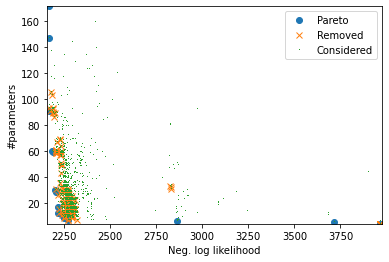

In [15]:
plt.axis([min(par_x)-x_buffer,
          max(par_x)+x_buffer,
          min(par_y)-y_buffer,
          max(par_y)+y_buffer])
plt.plot(par_x, par_y, 'o', label='Pareto')
plt.plot(rem_x, rem_y, 'x', label='Removed')
plt.plot(con_x, con_y, ',', label='Considered')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.legend()